# Opmap Tutorial

心臓光学マッピングの解析用Pythonモジュール ***Opmap*** のチュートリアルです。


## section 1. 膜電位マップ

まず、 ***VmemMap*** クラスをimportします。

In [2]:
%matplotlib inline

from opmap import VmemMap

次に、パラメータを作成します。

In [3]:
# 反転正規化用パラメータ
#'path' : '/Volumes/Recordings/ExperimentData/20140911-2/C001H001S0008/',
param_vmem = {
    'path' : './sample_session/',
    'cam_type'  : 'sa4',
    'image_width' : 512,
    'image_height' : 512,
    'frame_start' : 0,
    'frame_end' : 500,
    "range_min" : 50,  
    "range_max" : 150
}

各パラメータの説明は以下のとおりです。

* path : 録画ファイルが保存されているフォルダ
* cam_type : カメラ種別（現在対応済み：'sa4'のみ)
* image_width : 画像幅[pixel]
* image_height : 画像高さ[pixel]
* frame_start/end : 開始/終了フレーム（フォルダ内で一番若い番号のファイルが０番フレーム）
* range_min/max : 画素値変化幅の最小値・最大値

### 読み込み

作成したパラメータにもとづいてデータを読み込みます。

(※ しばらく時間がかかります)

(※ あまりに大きい画像を大量に読み込もうとするとメモリ不足になることがあります。)

In [4]:
vmem = VmemMap(**param_vmem)

読み込みが完了すると、すべての時間フレームの膜電位マップが、変数 ***vmem*** に格納されている状態になります。

### 画像の可視化

画像を可視化して確認してみます。

フレーム番号を指定して、１枚の画像を表示するには ***showFrame***を使います。

./sample_session/C001H001S0009000201.raww


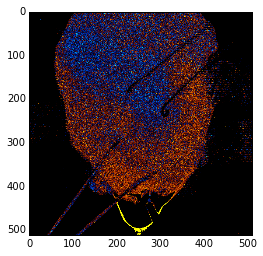

In [4]:
vmem.showFrame(frame=200)

この膜電位マップは、ROI以外の領域は黒く塗りつぶされています。

ROIは反転正規化の際に、各画素における信号の変化幅が有効範囲内(range_min~range_max)の領域として抽出されています。

以下のようにすればROIを可視化し確認できます。

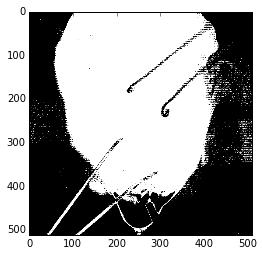

In [5]:
import matplotlib.pyplot as plt
plt.imshow(vmem.roi, cmap='gray')

### 画像の保存

膜電位マップをまとめて保存するには ***saveImage***を使います。

引数で保存する場所を指定します。

In [6]:
#vmem.saveImage("./result/vmem")

指定したフォルダを開き、膜電位画像が連番で保存されているのを確認してください。

### 波形の描画

次に、時間波形を描画してみます。

まず、時間波形を抽出する点の座標のリストを作成します。

In [7]:
points = [(255,255), (255, 265), (255, 275)]

(x座標, y座標)を、［］の中にカンマ区切りで羅列します。

最後に***plot***を使って時系列グラフを描画します。

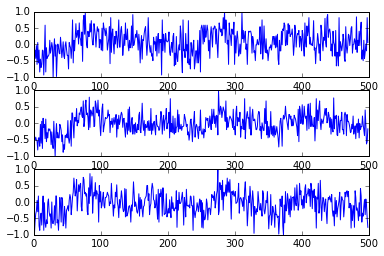

In [8]:
vmem.plot(points)

時間方向のフィルタをかけて描画する事もできます。

filter_size に奇数の値を指定して***plot***を実行して下さい。

（***vmem***に格納されているデータには影響しません。)

さらに、savepathを指定することでグラフ画像を保存できます。

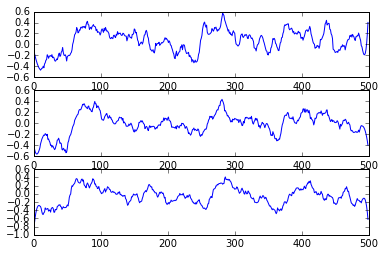

In [9]:
vmem.plot(points, filter_size = 19, savepath = './wave_vmem.png')

同じ画像がファイルに保存されているのを確認してみましょう。

### スムージング

膜電位マップにスムージングをかけます。

In [10]:
vmem.smooth(image=3)

これで、***vmem***に格納された全マップにサイズ3のgaussianフィルタがかかります。

（※スムージング前の元データは上書きされるので注意して下さい）

これまで同様に、画像の可視化や保存、波形の描画ができます。

./sample_session/C001H001S0009000201.raww


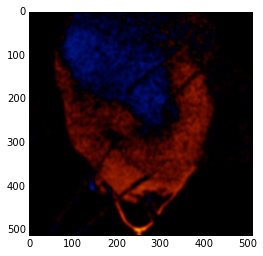

In [11]:
vmem.showFrame(frame=200)

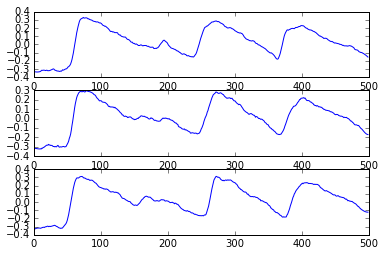

In [12]:
vmem.plot(points, filter_size =19, savepath='./wave_vmem_filtered.png')

## section 2. 位相マップ

In [8]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from cmap_bipolar import bipolar
from scipy import signal, ndimage
from scipy.interpolate import interp1d, splrep, splev

In [9]:
from opmap import SaveImage

In [56]:
def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value    

class PhaseMap(object):
    
    def __init__(self, vmem, cl = 40, shrink = 4, fs = 1000.0):
        assert len(vmem.data.shape) == 3
        assert cl > 0
        
        size_org = vmem.data.shape
        self.data = np.zeros((size_org[0],size_org[1]/shrink, size_org[2]/shrink), dtype=np.float32 )
        print self.data.shape
        
        nyq = fs/2.0
        fe = 20 / nyq   # Cut off frequency : 20Hz
        numtaps = 15  # Filter size
        b = signal.firwin(numtaps, fe) # Low pass filter
        
        for n in range(self.data.shape[1]):
            for m in range(self.data.shape[2]):
                n_ = n*shrink
                m_ = m*shrink       
                try:
                    assert vmem.roi[n_, m_] > 0
                    data = vmem.data[ :, n_, m_]
                    data_an = signal.lfilter(b, 1, data)
                    data_max = np.max(data_an)
                    data_min = np.min(data_an)
                    assert data_max > data_min
                    data_an  = 2.0 * (data_an - data_min) / (data_max - data_min) - 1.0
                    self.data[:, n, m] = np.angle(signal.hilbert(data_an))
                except:
                    self.data[:, n, m] = 0.0
                    
    def smooth(self, size = 4):
        assert size > 0
        new_data = np.zeros_like(self.data)
        for frame in range( self.data.shape[0]):
            if frame % 10 == 0 : print frame
            for n in range(self.data.shape[1])[size:-size]:
                for m in range(self.data.shape[2])[size:-size]:
                    base = self.data[frame, n, m]
                    target = self.data[frame, n-size:n+size+1, m-size:m+size+1]
                    difference = phaseComplement(target-base)
                    diff = signal.medfilt2d(difference, kernel_size=size*2+1)[size,size]
                    new_data[frame, n, m] = phaseComplement( base +  diff)
                    #new_data[frame, n, m] = phaseComplement( base + np.mean(difference.flatten()) )
        self.data = new_data
                    
    def showFrame(self, frame):
        assert frame >= 0 and frame < self.data.shape[0]
        print self.files[frame]
        plt.imshow(self.data[frame, :, :], vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='nearest')
    
    def saveImage(self, savedir):
        SaveImage(
            self.data, savedir, vmin=-np.pi, vmax=np.pi, cmap='jet'
        )
        


In [57]:
pmap = PhaseMap(vmem)

(500, 128, 128)


In [58]:
pmap.smooth()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


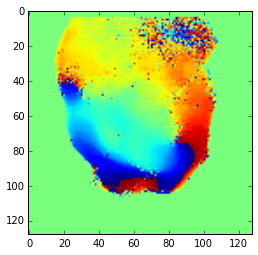

In [59]:
plt.imshow(pmap.data[280, :,:])

In [60]:
pmap.saveImage('./result/phase/')